In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
random_state = 0
# rng = np.random.default_rng(0)
rng = np.random.RandomState(random_state)

In [3]:
def normalize(v, eps=1e-9):
    n = np.linalg.norm(v) + eps
    return v / n

In [4]:
bianry_to_decimal = lambda binary_list: int(''.join(map(str, binary_list)), 2)

user_dim = 5
user_vec = (rng.rand(user_dim) > 0.5).astype(np.int64)

In [5]:
####################################################################################################
class AgentTS:
    id = -1
    true_compatibility_dim = rng.randint(20,50)
    
    def __init__(self, user_dim=4, compatibility_dim=16, lambda0=1, noise_sigma=0.1, forgetting_decay=1, sparsity = 0.2):
        # uhknown true compatibility vector
        self.user_dim = user_dim
        
        
        # True Compativility ---------------------------------------------------------------------
        # raw = rng.normal(size=AgentTS.true_compatibility_dim)
        raw = rng.uniform(low=-0.5, high=0.5, size=AgentTS.true_compatibility_dim)
        mask = (rng.rand(AgentTS.true_compatibility_dim) < sparsity).astype(float)
        raw *= mask

        # 모든 차원이 0이 되는 극단 케이스는 피하기 위해 한 번 더 체크
        if np.all(raw == 0):
            # 최소 한 개는 활성화
            idx = rng.randint(AgentTS.true_compatibility_dim)
            raw[idx] = rng.normal()
        self.true_compatibility = normalize(raw)
        # self.true_compatibility = normalize(
        #     rng.uniform(low=-1, high=1, size=AgentTS.true_compatibility_dim)
        #     )
        # -----------------------------------------------------------------------------------
        
        self.user_vec = (rng.rand(user_dim) > 0.5).astype(np.int64)
        self.user_vec_group = int(''.join(map(str, self.user_vec)), 2)
        
        AgentTS.id += 1
        self.id = AgentTS.id
        
        # info
        self.compatibility_dim = compatibility_dim
        self.noise_sigma = noise_sigma
        self.lambda0 = lambda0      # λ_0·I : Ridge Reguarization parameters (얼마나 prior를 신뢰할지?)
        self.forgetting_decay = forgetting_decay
        
        self.reset_params()
        # self.A = lambda0 * np.eye(compatibility_dim)
        # self.b = np.zeros(compatibility_dim)
        
        # self.Sigma = np.linalg.inv(self.A)      # 현재 추정된 compatibility Covariance
        # self.mu = rng.uniform(size=compatibility_dim)*0.1
    
    def reset_params(self):
        self.A = self.lambda0 * np.eye(self.compatibility_dim)
        self.b = np.zeros(self.compatibility_dim)
        
        self.Sigma = np.linalg.inv(self.A)      # 현재 추정된 compatibility Covariance
        self.mu = rng.uniform(size=self.compatibility_dim)*0.1
    
    def update(self, compatibility_other, r, Sigma_other=None, inplace=True):
        x_compatibility = compatibility_other.copy()
        A = self.forgetting_decay * self.A
        b = self.forgetting_decay * self.b
        
        E_xx = np.outer(x_compatibility, x_compatibility)
        if Sigma_other is not None:
            E_xx += Sigma_other
        A += (1/ self.noise_sigma) * E_xx    # += 1/(σ^2) * (X_I^T X_I)
        b += (1/ self.noise_sigma) * x_compatibility * r        # +=  1/(σ^2) * (X_I r)
        
        Sigma = np.linalg.inv(A)
        mu = Sigma @ b
        
        if inplace is True:
            self.A = A
            self.b = b
            self.Sigma = Sigma
            self.mu = mu
        
        return mu, Sigma
    
    def sampling(self):
        return rng.multivariate_normal(self.mu, self.Sigma)
    
    def __repr__(self):
        return f"UserAgent_{self.id}"

# COMPATIBILITY_DIM = 16
# users = [AgentTS(user_dim=4, compatibility_dim=COMPATIBILITY_DIM) for _ in range(5)]

In [6]:
####################################################################################################
class TrueCompatibilityNet(nn.Module):
    def __init__(self, compatibility_dim):
        super().__init__()
        self.compatibility_dim = compatibility_dim
        self.block = nn.Sequential(
            nn.Linear(compatibility_dim, compatibility_dim*2)
            ,nn.ReLU()
            ,nn.Linear(compatibility_dim*2, compatibility_dim*4)
            ,nn.ReLU()
            ,nn.Linear(compatibility_dim*4, compatibility_dim*2)
            ,nn.ReLU()
            ,nn.Linear(compatibility_dim*2, compatibility_dim)
        )
        
    def forward(self, x):
        return self.block(torch.FloatTensor(x)).detach().to('cpu').numpy()

# true_net = TrueCompatibilityNet(AgentTS.true_compatibility_dim)
# true_net(users[0].true_compatibility)
# true_net( np.stack([user.true_compatibility for user in users]) ).shape

In [7]:
####################################################################################################
# ---------- Helpers: upper-tri vectorization ----------
def triu_indices(k, device=None, dtype=torch.long):
    return torch.triu_indices(k, k, offset=0, device=device, dtype=dtype)

def vec_to_triu(vec, k, device=None):
    """
    vec: (..., k*(k+1)//2)
    return: (..., k, k) upper-triangular matrix with zeros elsewhere
    """
    idx = triu_indices(k, device=vec.device)
    out = vec.new_zeros(*vec.shape[:-1], k, k)
    out[..., idx[0], idx[1]] = vec
    return out

def triu_to_vec(U):
    """
    U: (..., k, k) upper-triangular
    return: (..., k*(k+1)//2)
    """
    k = U.shape[-1]
    idx = triu_indices(k, device=U.device)
    return U[..., idx[0], idx[1]]

In [8]:
####################################################################################################

class CategorialEmbedding(nn.Module):
    def __init__(self, n_features, num_embeddings, embedding_dim):
        super().__init__()
        self.nf, self.ne, self.ed = n_features, num_embeddings, embedding_dim
        self.embedding = nn.Embedding(n_features * num_embeddings, embedding_dim)

    def forward(self, x):
        # x: (..., n_features), long
        *batch, F = x.shape
        device = x.device
        feature_idx = torch.arange(F, device=device).view(*([1]*len(batch)), F).expand(*x.shape)
        flat_idx = feature_idx * self.ne + x                        # (..., F)
        out = self.embedding(flat_idx)                                      # (..., F, ed)
        return out

class ResidualConnection(nn.Module):
    def __init__(self, block, shortcut=None):
        super().__init__()
        self.block = block
        self.shortcut = shortcut or (lambda x: x)
    
    def forward(self, x):
        return self.block(x) + self.shortcut(x)


In [9]:
######################################################################################################
class ThompsonSamplingFeatureMap(nn.Module):
    def __init__(self, output_dim, user_dim, user_embed_dim, preference_embed_dim, 
                hidden_dim=64, max_users=10000, dropout=0.1, lambda0=1e-5):
        super().__init__()
        self.user_info_embedding = CategorialEmbedding(user_dim, max_users, embedding_dim=user_embed_dim)
        self.preference_embedding = nn.Embedding(max_users, embedding_dim=preference_embed_dim)
        
        concat_dim = (user_dim*user_embed_dim) + preference_embed_dim
        self.backbone = nn.Sequential(
            nn.Linear(concat_dim, hidden_dim)
            ,nn.ReLU()
            ,ResidualConnection(nn.Sequential(
                nn.BatchNorm1d(hidden_dim),
                nn.Linear(hidden_dim, hidden_dim)
                ,nn.ReLU()
                ,nn.Dropout(dropout)
                )
            )
            # ,ResidualConnection(nn.Sequential(
            #     nn.BatchNorm1d(hidden_dim),
            #     nn.Linear(hidden_dim, hidden_dim)
            #     ,nn.ReLU()
            #     ,nn.Dropout(dropout)
            #     )
            # )
        )
        
        # head
        self.output_dim = output_dim
        self.tdim = output_dim * (output_dim+1)//2
        
        self.softplus = nn.Softplus(beta=1.0)
        self.mu_head = nn.Linear(hidden_dim, output_dim)
        self.triu_head = nn.Linear(hidden_dim, self.tdim)
        
        # cache diagonal indices in the triu-vector
        self.lambda0 = lambda0
        di_rows, di_cols = torch.triu_indices(output_dim, output_dim, offset=0)
        diag_mask = (di_rows == di_cols)
        self.register_buffer("diag_mask", diag_mask)  # shape [tdim] : (register_buffer : 역전파로 업데이트되지 않지만 모델과 함께 저장/로드(move to cuda 등)되는 값)

    def vec_to_triu(self, vec, k):
        """
        vec: (..., k*(k+1)//2)
        return: (..., k, k) upper-triangular matrix (zeros elsewhere)
        """
        idx = torch.triu_indices(k, k, device=vec.device)
        out = vec.new_zeros(*vec.shape[:-1], k, k)
        out[..., idx[0], idx[1]] = vec
        return out

    def forward(self, user_vec:torch.LongTensor, user_id:torch.LongTensor):
        batch_size = user_vec.shape[:-1]
        
        user_emb = self.user_info_embedding(user_vec).view(*batch_size, -1)
        pref_emb = self.preference_embedding(user_id).view(*batch_size, -1)
        x_concat = torch.cat([user_emb, pref_emb], dim=-1)
        
        # backbone
        x_latent = self.backbone(x_concat)
        
        # mu
        mu = self.mu_head(x_latent)
        
        # U
        raw_triu = self.triu_head(x_latent)  # unconstrained
        diag_part = raw_triu[..., self.diag_mask]
        off_part  = raw_triu[..., ~self.diag_mask]
        
        # constrain diagonal: positive with softplus + epsilon
        diag_part = self.softplus(diag_part) + self.lambda0
        
        U_triu = raw_triu.clone()       # .clone()도 gradient 전파 가능 # 파이토치에서 inplace 연산은 그래프 추적 중에 이전 연산에 영향을 줄 수 있기 때문에 종종 에러를 발생시킨다.
        U_triu[..., self.diag_mask] = diag_part
        U_triu[..., ~self.diag_mask] = off_part
        
        U = self.vec_to_triu(U_triu, self.output_dim)   # (..., k, k)
        Lambda = U.transpose(-2, -1) @ U 
        
        return mu, U, Lambda

    # @torch.no_grad()
    def U_to_L(self, U:torch.Tensor):
        """
        Given U (upper of precision), compute Sigma = (U^T U)^{-1} without explicit inverse.
        Solve (U^T) Y = I  ->  L = U^{-T}
        """
        k = U.shape[-1]
        I = torch.eye(k, device=U.device, dtype=U.dtype).expand(U.shape[:-2] + (k, k))
        # U^T is lower-triangular
        L = torch.linalg.solve_triangular(U.transpose(-2, -1), I, upper=False, left=True)
        return L
    
    def gaussian(self, mu, U, requires_grad=False):
        ctx = torch.enable_grad() if requires_grad else torch.no_grad()
        with ctx:
            L = self.U_to_L(U)
            Sigma = L @ L.transpose(-2,-1)
        return mu, Sigma
    
    def forward_gaussian(self, user_vec:torch.LongTensor, user_id:torch.LongTensor):
        mu, U, Lambda = self.forward(user_vec, user_id)
        return self.gaussian(mu, U)
    
    def sampling(self, mu, U, n_samples=1, requires_grad=False):
        ctx = torch.enable_grad() if requires_grad else torch.no_grad()
        
        with ctx:
            L = self.U_to_L(U)
            multivariate_gaussian_dist = torch.distributions.MultivariateNormal(loc=mu, scale_tril=L)
            # multivariate_gaussian_dist = torch.distributions.MultivariateNormal(loc=mu, precision_matrix=Lambda)
            samples = multivariate_gaussian_dist.rsample((n_samples,))  # (n_sample, batch , dim) rsample: 미분가능, sample: 미분불가
            samples = torch.movedim(samples, 0, -2) # (batch, n_sample, dim)
        return samples
    
    # @torch.no_grad()
    def forward_sampling(self, user_vec:torch.LongTensor, user_id:torch.LongTensor, n_samples=1):
        """
        Thompson-style sampling: c = mu + U^{-T} z,  z ~ N(0,I)
        returns (..., n_samples, k)
        """
        mu, U, Lambda = self.forward(user_vec, user_id)
        return self.sampling(mu, U)

####################################################################################################
# users[0].id
# users[0].user_vec
# users[0].user_vec_group
# model = ThompsonSamplingFeatureMap(COMPATIBILITY_DIM, users[0].user_dim,
#                                    user_embed_dim=3, preference_embed_dim=8)
# a = torch.LongTensor([users[0].user_vec]).repeat(5,1)
# b = torch.LongTensor([[users[0].id]]).repeat(5,1)
# a = torch.LongTensor([users[0].user_vec])
# b = torch.LongTensor([[users[0].id]])

# model(a,b)[0].shape
# model(a,b)[1].shape
# model(a,b)[2].shape
# model.forward_gaussian(a,b)
# model.forward_sample(a,b, n_samples=1).shape

In [10]:
# -----------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------
# Global Optima Matching
# 1) hungarian matching
from scipy.optimize import linear_sum_assignment
def hungarian(similarity_matrix):
    S_max = similarity_matrix.max()         # 행렬 최대값
    cost_matrix = S_max - similarity_matrix     # 비용행렬
    np.fill_diagonal(cost_matrix, np.inf)

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    optimal_matching_values = similarity_matrix[row_ind, col_ind]
    matching_result = np.concatenate([row_ind[np.newaxis,...].T, col_ind[np.newaxis,...].T], axis=-1).T
    return matching_result, optimal_matching_values


# 2) 일반 그래프 최대 가중 매칭(Blossom)
import networkx as nx
def blossom_max_weight_matching(similarity_matrix):
    n = similarity_matrix.shape[0]
    G = nx.Graph()
    for i in range(n):
        for j in range(i+1, n):
            w = similarity_matrix[i, j]
            if np.isfinite(w):
                G.add_edge(i, j, weight=float(w))
    # 최대 가중 + 최대 카디널리티(가능한 많이 페어링)
    matching = nx.algorithms.matching.max_weight_matching(
        G, maxcardinality=True, weight='weight'
    )

    # matching result processing
    pair_half = list(matching)  # (i, j) 튜플들의 집합
    pair_half_np =  np.stack(pair_half)
    pair_np = np.concatenate([pair_half_np, pair_half_np[:, ::-1]], axis=0)
    sort_idx = np.argsort(pair_np[:,0])
    matching_result = pair_np[sort_idx].T

    # optimal_matching_values
    row_ind = matching_result[0]
    col_ind = matching_result[1]
    optimal_matching_values = similarity_matrix[row_ind, col_ind]
    return matching_result, optimal_matching_values

In [11]:
# -----------------------------------------------------------------------------------------------
# Local Optima Matching
import numpy as np
def greedy_matching(similarity_matrix):
    """
    유사도 행렬을 한 번 정렬한 후 탐욕적으로 매칭을 수행합니다.
    O(N^2 log N) 복잡도로, O(N^3)에 가까운 반복적 argmax 방식보다 빠릅니다.

    Args:
        similarity_matrix (np.ndarray): N x N 유사도 행렬.

    Returns:
        tuple: (matching_result, optimal_matching_values)
    """
    N = similarity_matrix.shape[0]

    # 1. 유사도 행렬에서 매칭 후보 쌍(i, j)만 추출합니다. (i < j 조건)
    # 삼각 행렬 인덱스 추출 (자기 자신과의 매칭 방지)
    iu = np.triu_indices(N, k=1)

    # 2. 모든 유사도 값을 추출하고 내림차순으로 정렬합니다.
    flat_similarities = similarity_matrix[iu]

    # 유사도 값이 높은 순서(내림차순)로 정렬하기 위한 인덱스
    sort_idx = np.argsort(flat_similarities)[::-1]

    # 정렬된 유사도 값과 해당 쌍의 인덱스
    sorted_values = flat_similarities[sort_idx]
    sorted_pairs = np.column_stack(iu)[sort_idx] # (row, col) 쌍

    # 매칭 결과를 저장할 리스트와 매칭된 유저 집합
    matched_pairs = []
    matched_values = []
    matched_indices = set()

    # 3. 정렬된 쌍을 순회하며 매칭합니다. (O(N^2) 순회)
    for value, (i, j) in zip(sorted_values, sorted_pairs):
        # 이미 i 또는 j가 매칭되었는지 확인 (O(1) set lookup)
        if i not in matched_indices and j not in matched_indices:
            # 매칭 확정
            matched_pairs.append((i, j))
            matched_values.append(value)

            # 유저 제거 (논리적 제거)
            matched_indices.add(i)
            matched_indices.add(j)

            # 매칭이 절반 이상 완료되면 종료
            if len(matched_indices) >= N - 1:
                break

    if not matched_pairs:
        return np.array([[], []]), np.array([])

    # 4. 결과 포맷팅 (이 부분은 이전 코드와 동일)
    matched_pairs_np = np.array(matched_pairs)

    # (i, j)뿐만 아니라 (j, i)도 포함
    all_pairs = np.concatenate([matched_pairs_np, matched_pairs_np[:, ::-1]], axis=0)
    all_values = np.concatenate([np.array(matched_values), np.array(matched_values)], axis=0)

    # 행 인덱스(user_i) 기준으로 정렬
    sort_idx = np.argsort(all_pairs[:, 0])
    matching_result = all_pairs[sort_idx].T
    optimal_matching_values = all_values[sort_idx]

    return matching_result, optimal_matching_values



class KNN_GreedyMatching():
    def __init__(self, k=None):
        self.k = k

    def knn_greedy_matching(self, similarity_matrix):
        """
        유사도 행렬을 기반으로, 각 유저의 k명의 가장 유사한 후보군 내에서만
        탐욕적으로 매칭을 수행하는 근사 매칭 함수입니다.

        Args:
            similarity_matrix (np.ndarray): N x N 유사도 행렬.
            k (int): 각 유저가 고려할 이웃의 최대 수.

        Returns:
            tuple: (matching_result, optimal_matching_values)
                matching_result (np.ndarray): 매칭된 쌍의 인덱스 (2, M).
                optimal_matching_values (np.ndarray): 매칭된 쌍의 유사도 값 (M,).
        """
        N = similarity_matrix.shape[0]
        k = self.k
        if k is None or (k >= N - 1):
            # k가 N보다 크면 그냥 일반적인 탐욕적 매칭과 동일
            return greedy_matching(similarity_matrix)

        # 1. k-NN 기반 후보 쌍만 추출하여 정렬합니다.

        # 1-1. 각 유저별 k명의 이웃 인덱스를 찾습니다.
        # np.argsort는 기본적으로 오름차순. [::-1]로 내림차순 정렬 후, k개 선택.
        # 자기 자신(가장 유사도 1.0)을 제외하고, 인접한 k개의 인덱스를 찾습니다.

        # 유사도 행렬의 각 행(유저 i)에서 k+1번째로 유사한 인덱스까지
        # 즉, 자기 자신(0순위) 포함 k+1개
        k_plus_1_indices = np.argsort(similarity_matrix, axis=1)[:, ::-1][:, :k+1]

        # 1-2. 매칭 후보 (쌍) 리스트 생성
        # 모든 유저 i에 대해, 그들의 k-NN 후보 j만을 추출합니다. (i < j 조건 만족)
        # 이는 중복 쌍을 피하고 대칭성을 깨지 않기 위함입니다.

        candidate_pairs = set()

        for i in range(N):
            # 유저 i의 k-NN 후보 목록
            neighbors = k_plus_1_indices[i]

            for j in neighbors:
                # 1. 자기 자신과의 매칭 제외
                if i == j:
                    continue
                # 2. 이미 (j, i)로 처리된 쌍을 피하기 위해 정규화된 쌍 (min, max)만 추가
                pair = tuple(sorted((i, j)))
                candidate_pairs.add(pair)

        # 2. 후보 쌍의 유사도 값을 추출하고 내림차순으로 정렬합니다.

        # 후보 쌍 (i, j)와 해당 유사도 값 추출
        pairs_list = np.array(list(candidate_pairs))
        flat_similarities = similarity_matrix[pairs_list[:, 0], pairs_list[:, 1]]

        # 유사도 값이 높은 순서(내림차순)로 정렬하기 위한 인덱스
        sort_idx = np.argsort(flat_similarities)[::-1]

        sorted_values = flat_similarities[sort_idx]
        sorted_pairs = pairs_list[sort_idx]

        # 3. 탐욕적으로 매칭합니다. (나머지 과정은 optimized_greedy_matching과 동일)

        matched_pairs = []
        matched_values = []
        matched_indices = set()

        for value, (i, j) in zip(sorted_values, sorted_pairs):
            if i not in matched_indices and j not in matched_indices:
                # 매칭 확정
                matched_pairs.append((i, j))
                matched_values.append(value)

                # 유저 제거
                matched_indices.add(i)
                matched_indices.add(j)

                if len(matched_indices) >= N - 1:
                    break

        if not matched_pairs:
            return np.array([[], []]), np.array([])

        # 4. 결과 포맷팅
        matched_pairs_np = np.array(matched_pairs)

        # (i, j)뿐만 아니라 (j, i)도 포함하여 정렬
        all_pairs = np.concatenate([matched_pairs_np, matched_pairs_np[:, ::-1]], axis=0)
        all_values = np.concatenate([np.array(matched_values), np.array(matched_values)], axis=0)

        # 행 인덱스(user_i) 기준으로 정렬
        sort_idx = np.argsort(all_pairs[:, 0])
        matching_result = all_pairs[sort_idx].T
        optimal_matching_values = all_values[sort_idx]

        return matching_result, optimal_matching_values

# ----------------------------------------------------------------------------------------------

In [12]:
# ########################################################################################
# USER_DIM = 4
# COMPATIBILITY_DIM = 16
# USER_EMBEDDING_DIM = 3
# PREFERENCE_EMBEDDING_DIM = 8
# users = [AgentTS(user_dim=USER_DIM, compatibility_dim=COMPATIBILITY_DIM) for _ in range(6)]

# # (True matching) -------------------------------------------------------------------
# users_true_vec = np.array([user.true_compatibility for user in users])
# users_true_vec

# # # true net
# # true_net = TrueCompatibilityNet(AgentTS.true_compatibility_dim)
# # users_true_vec = true_net(users_true_vec)
# SM_true = users_true_vec @ users_true_vec.T

# # true_matching, true_matching_values = hungarian(SM_true)  # True matching
# true_matching, true_matching_values = blossom_max_weight_matching(SM_true)  # True matching
# print('< true_matching >')
# print(true_matching)
# print(true_matching_values)
# # ------------------------------------------------------------------------------------

# # sample matching
# TS_model = ThompsonSamplingFeatureMap(COMPATIBILITY_DIM, USER_DIM, USER_EMBEDDING_DIM, PREFERENCE_EMBEDDING_DIM)

# users_vec = torch.LongTensor( np.stack([user.user_vec for user in users]) )
# users_id = torch.LongTensor( np.stack([[user.id] for user in users]) )

# compatibility_samples = TS_model.forward_sample(users_vec, users_id).squeeze(-2)
# compatibility_samples_np = compatibility_samples.detach().to('cpu').numpy()

# SM_samples = compatibility_samples_np @ compatibility_samples_np.T

# # sample_matching, sample_matching_values = hungarian(SM_samples)
# sample_matching, sample_matching_values = blossom_max_weight_matching(SM_samples)
# print('< sampling_matching >')
# print(sample_matching)
# print(sample_matching_values)

In [13]:
########################################################################################
# After Maching, Revealed Rewards
def revealed_reward(true_similarity_matrix, sample_matching, noise_std=0.1):
    mu_rewards = true_similarity_matrix.copy()
    # true_similarity_matrix_copy = true_similarity_matrix.copy()
    # np.fill_diagonal(true_similarity_matrix_copy, -np.inf)
    # np.exp(true_similarity_matrix_copy) / np.exp(true_similarity_matrix_copy).sum(axis=1)
    # mu_rewards = 1/2*(np.exp(true_similarity_matrix_copy) / np.exp(true_similarity_matrix_copy).sum(axis=0)) + 1/2*(np.exp(true_similarity_matrix_copy) / np.exp(true_similarity_matrix_copy).sum(axis=0)).T

    reward_noise_gen = rng.random(size=mu_rewards.shape)*noise_std-noise_std/2
    reward_noise_gen = (reward_noise_gen + reward_noise_gen.T)/2
    np.fill_diagonal(reward_noise_gen, 0)

    revealed_rewards = mu_rewards+reward_noise_gen
    # revealed_rewards = np.clip(mu_rewards+reward_noise_gen, a_min=0, a_max=1)
    return revealed_rewards[sample_matching[0], sample_matching[1]]

# rewards_obs = revealed_reward(SM_true, sample_matching)
# print(f"revealed rewards : {rewards_obs}")
########################################################################################


# rewards = revealed_reward(SM_true, sample_matching)
# mu_target, Sigma_target = users[0].update(compatibility_samples_np[3], rewards[0], users[3].Sigma, inplace=True)

In [14]:
##########################################################################################

def calculate_target_pair(idx_i:float, idx_j:int, 
                    reward:float, users:AgentTS, compatibility_samples:np.array, inplace:bool=True):
    mu_target_i, Sigma_target_i = users[idx_i].update(compatibility_samples[idx_j], reward, users[idx_j].Sigma, inplace=inplace)
    mu_target_j, Sigma_target_j = users[idx_j].update(compatibility_samples[idx_i], reward, users[idx_i].Sigma, inplace=inplace)
    return (mu_target_i, Sigma_target_i), (mu_target_j, Sigma_target_j)
    
def calculate_targets(rewards, users, compatibility_samples, sample_matching, inplace=True):
    mu_targets = [np.array([])]*len(users)
    Sigma_targets = [np.array([])]*len(users)
    for reward, match in zip(rewards, sample_matching.T):
        idx_i = match[0]
        idx_j = match[1]
        
        if len(mu_targets[idx_i]) ==0 and len(mu_targets[idx_j]) ==0:
            (mu_target_i, Sigma_target_i), (mu_target_j, Sigma_target_j) = calculate_target_pair(idx_i, idx_j, reward, users, compatibility_samples, inplace)
            mu_targets[idx_i] = mu_target_i
            mu_targets[idx_j] = mu_target_j
            Sigma_targets[idx_i] = Sigma_target_i
            Sigma_targets[idx_j] = Sigma_target_j
    return mu_targets, Sigma_targets


In [15]:
# -----------------------------------------------------------------------
def kl_gaussian_full(mu0, Sigma0, mu1, Sigma1, eps=1e-6, reduction: str = "mean"):
    """
    Multivariate Gaussian KL(N0 || N1)
    N0 ~ N(mu0, Sigma0)
    N1 ~ N(mu1, Sigma1)

    mu0, mu1: (..., D)
    Sigma0, Sigma1: (..., D, D)  (대칭, 양의정부호라고 가정)
    """
    # 차원
    D = mu0.shape[-1]

    # 작은 값 더해서 수치적으로 안정화
    eye = eps * torch.eye(D, device=mu0.device, dtype=mu0.dtype)
    Sigma0 = Sigma0 + eye
    Sigma1 = Sigma1 + eye

    # Sigma1^{-1}
    Sigma1_inv = torch.linalg.inv(Sigma1)

    # trace(Sigma1^{-1} Sigma0)
    # (..., D, D) x (..., D, D) -> (..., D, D) -> trace
    term_trace = torch.einsum('...ij,...jk->...ik', Sigma1_inv, Sigma0)
    term_trace = torch.einsum('...ii->...', term_trace)  # trace

    # (mu1 - mu0)^T Sigma1^{-1} (mu1 - mu0)
    diff = (mu1 - mu0).unsqueeze(-1)          # (..., D, 1)
    mahal = torch.matmul(Sigma1_inv, diff)    # (..., D, 1)
    mahal = torch.matmul(diff.transpose(-1, -2), mahal)  # (..., 1, 1)
    term_quad = mahal.squeeze(-1).squeeze(-1)            # (...,)

    # log det 부분: log(det(Sigma1)) - log(det(Sigma0))
    # slogdet: sign, logabsdet
    sign0, logdet0 = torch.linalg.slogdet(Sigma0)
    sign1, logdet1 = torch.linalg.slogdet(Sigma1)
    # sign이 -1이면 문제가 있는 covariance
    # 여기선 양의정부호를 가정하므로 sign == 1이라고 가정
    term_logdet = logdet1 - logdet0

    # KL = 0.5 * (trace + quad - D + logdet1 - logdet0)
    kl = 0.5 * (term_trace + term_quad - D + term_logdet)
    
    if reduction == "mean":
        return kl.mean()
    elif reduction == "sum":
        return kl.sum()
    else:  # 'none'
        return kl


# 
def kl_gaussian_prec_chol(
    mu_target: torch.Tensor,       # (B, k)
    cov_target: torch.Tensor,      # (B, k, k)   Σ_target
    mu_pred: torch.Tensor,         # (B, k)      μ_hat
    prec_chol_pred: torch.Tensor,  # (B, k, k)   U_hat : Σ_hat^{-1} = U^T U
    reduction: str = "mean"
):
    """
    KL( N(mu_target, cov_target) || N(mu_pred, cov_pred) )을 계산.
    cov_pred는 직접 입력하지 않고, prec_chol_pred (precision의 Cholesky factor)로부터 유도.

    mu_target, mu_pred   : (B, k)
    cov_target           : (B, k, k)
    prec_chol_pred (U)   : (B, k, k),  Σ_hat^{-1} = U^T U
    """
    eps = 1e-6

    B, k = mu_target.shape

    # 1) Σ_hat^{-1} = Λ_hat = U^T U
    precision_pred = prec_chol_pred.transpose(-1, -2) @ prec_chol_pred  # (B, k, k)

    # 2) tr( Σ_hat^{-1} Σ_target )
    #   term1 = tr( precision_pred @ cov_target )
    #   trace(AB) = sum_ij A_ij B_ji
    term1 = torch.einsum("bij,bji->b", precision_pred, cov_target)

    # 3) (μ_hat - μ_target)^T Σ_hat^{-1} (μ_hat - μ_target)
    diff = (mu_pred - mu_target).unsqueeze(-1)       # (B, k, 1)
    quad = diff.transpose(-1, -2) @ (precision_pred @ diff)  # (B, 1, 1)
    term2 = quad.squeeze(-1).squeeze(-1)             # (B,)

    # 4) log det Σ_hat  (prec_chol_pred는 Σ_hat^{-1}의 Cholesky factor)
    #    log det Σ_hat^{-1} = 2 * sum(log(diag(U)))
    diag_U = torch.diagonal(prec_chol_pred, dim1=-2, dim2=-1)  # (B, k)
    logdet_prec_pred = 2.0 * torch.log(diag_U + eps).sum(-1)   # (B,)
    logdet_cov_pred = -logdet_prec_pred                         # log det Σ_hat

    # 5) log det Σ_target  (표준 Cholesky 사용)
    #    cov_target = L L^T  → log det Σ_target = 2 * sum(log(diag(L)))
    L_target = torch.linalg.cholesky(cov_target + eps * torch.eye(k, device=cov_target.device))
    diag_L = torch.diagonal(L_target, dim1=-2, dim2=-1)         # (B, k)
    logdet_cov_target = 2.0 * torch.log(diag_L + eps).sum(-1)   # (B,)

    # 6) 전체 KL:
    #   KL = 1/2 [ tr(Σ_hat^{-1} Σ_target)
    #              + (μ_hat - μ_t)^T Σ_hat^{-1} (μ_hat - μ_t)
    #              - k
    #              + log( det Σ_hat / det Σ_target ) ]
    term3 = logdet_cov_pred - logdet_cov_target

    kl_per_sample = 0.5 * (term1 + term2 - k + term3)  # (B,)

    if reduction == "mean":
        return kl_per_sample.mean()
    elif reduction == "sum":
        return kl_per_sample.sum()
    else:  # 'none'
        return kl_per_sample


In [16]:
##########################################################################################
##########################################################################################
##########################################################################################
##########################################################################################

In [17]:

N_USERS = 100
USER_DIM = 4
USER_EMBEDDING_DIM = 4
PREFERENCE_EMBEDDING_DIM = 32
COMPATIBILITY_DIM = 12      # 실제 추정에 사용되는 궁합 벡터

In [18]:

users = [AgentTS(user_dim=USER_DIM, compatibility_dim=COMPATIBILITY_DIM, forgetting_decay=1) for _ in range(N_USERS)]

# (True matching) -------------------------------------------------------------------
users_true_vec = np.array([user.true_compatibility for user in users])


# # true net
# true_net = TrueCompatibilityNet(AgentTS.true_compatibility_dim)
# users_true_vec = true_net(users_true_vec)
SM_true = users_true_vec @ users_true_vec.T

# true_matching, true_matching_values = hungarian(SM_true)  # True matching
np.round(SM_true,2)
true_matching, true_matching_values = blossom_max_weight_matching(SM_true)  # True matching
print('< true_matching >')
print(true_matching)
print(true_matching_values)
print(f"total return rewards (true) : {true_matching_values.sum():.3f}")
# ------------------------------------------------------------------------------------

< true_matching >
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
  72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
  96 97 98 99]
 [29  3 20  1 61 41 23 93 28 40 44 35 71 64 34 88 58 49 84 57  2 42 25  6
  96 22 73 43  8  0 82 55 89 62 14 11 60 91 95 76  9  5 21 27 10 69 48 80
  46 17 66 67 97 85 81 31 59 19 16 56 36  4 33 98 13 92 50 51 86 45 99 12
  74 26 72 87 39 94 90 83 47 54 30 79 18 53 68 75 15 32 78 37 65  7 77 38
  24 52 63 70]]
[0.41405944 0.32123309 0.42952519 0.32123309 0.51030631 0.3575322
 0.49832681 0.31561988 0.484194   0.46539115 0.38188947 0.35374972
 0.35302433 0.3947115  0.45551178 0.38280822 0.35408966 0.35386071
 0.50274316 0.21777204 0.42952519 0.4164008  0.31220032 0.49832681
 0.36390501 0.31220032 0.49332942 0.40498398 0.484194   0.41405944
 0.27649431 0.36033484 0.

In [19]:
###################################################################################################
## (LinTS) ########################################################################################
# reset params
[user.reset_params() for user in users]

#  matching
rewards_obs_list = []


In [20]:
# matching
matching_function = greedy_matching
for _ in tqdm(range(1800)):
    # # user vector / id
    # users_vec = np.stack([user.user_vec for user in users])
    # users_id = np.stack([[user.id] for user in users])
    
    # sampling 
    users_samples_vec = np.stack([user.sampling() for user in users])
    
    # calculate similarity matrix
    SM_samples = users_samples_vec @ users_samples_vec.T
    # np.round(SM_samples,2)
    
    # users matching
    sample_matching, sample_matching_values = matching_function(SM_samples)
    
    # obseve rewards
    rewards_obs = revealed_reward(SM_true, sample_matching, noise_std=0.2)
    rewards_obs
    rewards_obs_list.append(np.sum(rewards_obs))
    
    # Users parameter Update
    calculate_targets(rewards_obs, users, users_samples_vec, sample_matching, inplace=True)

  0%|          | 0/1800 [00:00<?, ?it/s]

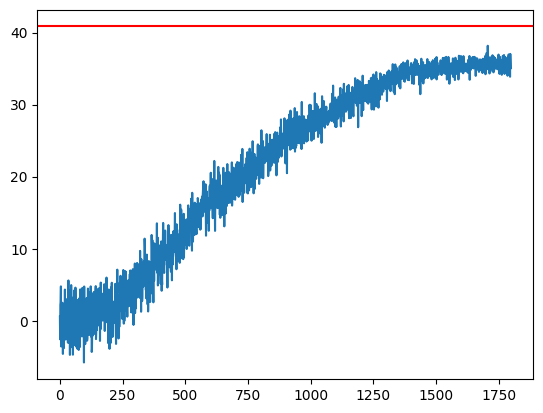

In [21]:

plt.plot(rewards_obs_list)
plt.axhline(np.sum(true_matching_values), color='red')
plt.show()

In [22]:
# sample matching
users_samples_vec = np.stack([user.mu for user in users])
SM_samples = users_samples_vec @ users_samples_vec.T

# sample_matching, sample_matching_values = hungarian(SM_samples)
sample_matching, sample_matching_values = blossom_max_weight_matching(SM_samples)
print('< sampling_matching >')
print(sample_matching)
print(sample_matching_values)
print(f"total return rewards (training) : {sample_matching_values.sum():.3f}")


< sampling_matching >
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
  72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
  96 97 98 99]
 [29  3 20  1 61 96 23 32 28 40 44 19 71 64 34 38 58 59 84 11  2 60 89  6
  57 94 30 43  8  0 26 67  7 62 14 91 75 66 15 76  9 42 41 27 10 69 48 80
  46 81 54 88 97 73 50 93 95 24 16 17 21  4 33 82 13 92 37 31 86 45 99 12
  74 53 72 36 39 98 90 83 47 49 63 79 18 87 68 85 51 22 78 35 65 55 25 56
   5 52 77 70]]
[ 0.41306116  0.31380791  0.43033673  0.31380791  0.51027186  0.30727632
  0.49390174 -0.00374795  0.48454555  0.46232327  0.37021346  0.21777504
  0.34431137  0.38837523  0.44955903  0.37711661  0.34758629  0.3569596
  0.50283973  0.21777504  0.43033673  0.33865447  0.28202922  0.49390174
  0.08308173  0.32417783  0.25276094  0.40236718  0.48454555  0.

In [23]:
print('< true_matching >')
print(true_matching)
print(true_matching_values)
print(f"total return rewards (true) : {true_matching_values.sum():.3f}")

< true_matching >
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
  72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
  96 97 98 99]
 [29  3 20  1 61 41 23 93 28 40 44 35 71 64 34 88 58 49 84 57  2 42 25  6
  96 22 73 43  8  0 82 55 89 62 14 11 60 91 95 76  9  5 21 27 10 69 48 80
  46 17 66 67 97 85 81 31 59 19 16 56 36  4 33 98 13 92 50 51 86 45 99 12
  74 26 72 87 39 94 90 83 47 54 30 79 18 53 68 75 15 32 78 37 65  7 77 38
  24 52 63 70]]
[0.41405944 0.32123309 0.42952519 0.32123309 0.51030631 0.3575322
 0.49832681 0.31561988 0.484194   0.46539115 0.38188947 0.35374972
 0.35302433 0.3947115  0.45551178 0.38280822 0.35408966 0.35386071
 0.50274316 0.21777204 0.42952519 0.4164008  0.31220032 0.49832681
 0.36390501 0.31220032 0.49332942 0.40498398 0.484194   0.41405944
 0.27649431 0.36033484 0.

In [24]:
####################################################################################################
# (DeepTS) #########################################################################################

In [25]:
users = [AgentTS(user_dim=USER_DIM, compatibility_dim=COMPATIBILITY_DIM, forgetting_decay=1) for _ in range(N_USERS)]

# (True matching) -------------------------------------------------------------------
users_true_vec = np.array([user.true_compatibility for user in users])


# # true net
# true_net = TrueCompatibilityNet(AgentTS.true_compatibility_dim)
# users_true_vec = true_net(users_true_vec)
SM_true = users_true_vec @ users_true_vec.T

# true_matching, true_matching_values = hungarian(SM_true)  # True matching
np.round(SM_true,2)
true_matching, true_matching_values = blossom_max_weight_matching(SM_true)  # True matching
print('< true_matching >')
print(true_matching)
print(true_matching_values)
print(f"total return rewards (true) : {true_matching_values.sum():.3f}")
# ------------------------------------------------------------------------------------

< true_matching >
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
  72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
  96 97 98 99]
 [66 12 75 27 97 78 32 91 46 13 20 15  1  9 25 11 22 82 56 61 10 23 16 21
  87 14 81  3 50 80 99 74  6 69 84 77 53 58 95 49 83 73 62 67 94 51  8 63
  86 39 28 45 71 36 92 57 18 55 37 85 96 19 42 47 70 68  0 43 65 33 64 52
  90 41 31  2 79 35  5 76 29 26 17 40 34 59 48 24 93 98 72  7 54 88 44 38
  60  4 89 30]]
[0.31706449 0.12613176 0.2586174  0.29204334 0.58486178 0.51581587
 0.23446946 0.60495221 0.36157614 0.38401057 0.26247353 0.44821427
 0.12613176 0.38401057 0.38288849 0.44821427 0.35907654 0.39309183
 0.2857028  0.31786953 0.26247353 0.34687454 0.35907654 0.34687454
 0.45511708 0.38288849 0.32313501 0.29204334 0.38084125 0.3858602
 0.5090078  0.32746659 0.

In [26]:

# reset params
[user.reset_params() for user in users]

# sample matching
TS_model = ThompsonSamplingFeatureMap(COMPATIBILITY_DIM, USER_DIM, USER_EMBEDDING_DIM, PREFERENCE_EMBEDDING_DIM)
optimizer = optim.Adam(TS_model.parameters(), lr=1e-3)

In [27]:
# # initialize ----------------------------------------------------------------------------------
# for i in range(1000):
#     users_vec = torch.LongTensor( np.stack([user.user_vec for user in users]) )
#     users_id = torch.LongTensor( np.stack([[user.id] for user in users]) )
#     # forward : mu, U, Lambda
#     mu_Hat, U_Hat, Lambda_Hat = TS_model(users_vec, users_id) # Gradient

#     mu_targets_tensor = torch.FloatTensor([user.mu for user in users])
#     Sigma_targets_tensor = torch.FloatTensor([user.Sigma for user in users])

#     # TS-Model Update (KL-divergence Loss)
#     loss = kl_gaussian_prec_chol(mu_targets_tensor, Sigma_targets_tensor, mu_Hat, U_Hat, reduction='mean')
#     loss = kl_gaussian_full(mu_targets_tensor, Sigma_targets_tensor, mu_Hat, torch.linalg.inv(Lambda_Hat), reduction='mean')
    
#     # model update
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     print(f"(ITER: {i}) loss : {loss.detach().to('cpu').numpy():.3f}")
# ------------------------------------------------------------------------------------------------


In [28]:
# matching
rewards_obs_list = []

In [29]:
# matching
# matching_function = KNN_GreedyMatching(k=int(np.sqrt(SM_true.shape[0]))).knn_greedy_matching   # hungarian, blossom_max_weight_matching, greedy_matching, KNN_GreedyMatching(k=10).knn_greedy_matching

N_UPDATES = 5
matching_function = greedy_matching
for i in range(1800):
    # user vector / id
    users_vec = torch.LongTensor( np.stack([user.user_vec for user in users]) )
    users_id = torch.LongTensor( np.stack([[user.id] for user in users]) )
    
    # forward : mu, U, Lambda
    mu_Hat, U_Hat, Lambda_Hat = TS_model(users_vec, users_id) # Gradient
    
    # sampling 
    compatibility_samples = TS_model.sampling(mu_Hat, U_Hat).squeeze(-2)
    compatibility_samples_np = compatibility_samples.to('cpu').numpy()
    
    # calculate similarity matrix
    SM_samples = compatibility_samples_np @ compatibility_samples_np.T

    # users matching
    sample_matching, sample_matching_values = matching_function(SM_samples)
    
    # obseve rewards
    rewards_obs = revealed_reward(SM_true, sample_matching, noise_std=0.2)
    rewards_obs_list.append(np.sum(rewards_obs))
    
    # calculate_targets    
    mu_targets, Sigma_targets = calculate_targets(rewards_obs, users, compatibility_samples_np, sample_matching, inplace=True)
    mu_targets_tensor = torch.FloatTensor(np.stack(mu_targets))
    Sigma_targets_tensor = torch.FloatTensor(np.stack(Sigma_targets))
    
    # TS-Model Update (KL-divergence Loss)
    loss = kl_gaussian_prec_chol(mu_targets_tensor, Sigma_targets_tensor, mu_Hat, U_Hat, reduction='mean')
    # loss = kl_gaussian_full(mu_targets_tensor, Sigma_targets_tensor,
    #                         mu_Hat, torch.linalg.inv(Lambda_Hat), reduction='mean')
    
    # model update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"(ITER: {i}) loss : {loss.detach().to('cpu').numpy():.3f}")
    
    for j in range(N_UPDATES-1):
        mu_Hat, U_Hat, Lambda_Hat = TS_model(users_vec, users_id) # Gradient
        loss = kl_gaussian_prec_chol(mu_targets_tensor, Sigma_targets_tensor, mu_Hat, U_Hat, reduction='mean')
        # loss = kl_gaussian_full(mu_targets_tensor, Sigma_targets_tensor,
        #                     mu_Hat, torch.linalg.inv(Lambda_Hat), reduction='mean')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

(ITER: 0) loss : 15.008
(ITER: 1) loss : 15.404
(ITER: 2) loss : 16.020
(ITER: 3) loss : 16.324
(ITER: 4) loss : 16.098
(ITER: 5) loss : 15.650
(ITER: 6) loss : 14.883
(ITER: 7) loss : 13.615
(ITER: 8) loss : 12.648
(ITER: 9) loss : 11.589
(ITER: 10) loss : 10.489
(ITER: 11) loss : 9.468
(ITER: 12) loss : 8.614
(ITER: 13) loss : 8.179
(ITER: 14) loss : 7.603
(ITER: 15) loss : 7.245
(ITER: 16) loss : 6.896
(ITER: 17) loss : 6.564
(ITER: 18) loss : 6.384
(ITER: 19) loss : 6.053
(ITER: 20) loss : 5.916
(ITER: 21) loss : 5.843
(ITER: 22) loss : 5.710
(ITER: 23) loss : 5.243
(ITER: 24) loss : 5.339
(ITER: 25) loss : 5.100
(ITER: 26) loss : 5.140
(ITER: 27) loss : 4.881
(ITER: 28) loss : 4.795
(ITER: 29) loss : 4.704
(ITER: 30) loss : 4.567
(ITER: 31) loss : 4.453
(ITER: 32) loss : 4.340
(ITER: 33) loss : 4.333
(ITER: 34) loss : 4.274
(ITER: 35) loss : 4.313
(ITER: 36) loss : 4.266
(ITER: 37) loss : 4.185
(ITER: 38) loss : 4.038
(ITER: 39) loss : 3.960
(ITER: 40) loss : 3.907
(ITER: 41) loss

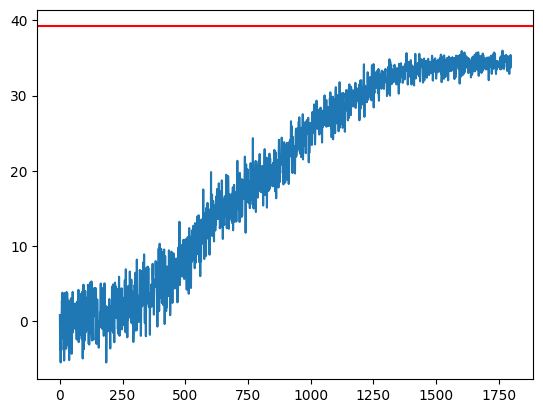

In [30]:
plt.plot(rewards_obs_list)
plt.axhline(np.sum(true_matching_values), color='red')
plt.show()

In [31]:
# sample matching
users_vec = torch.LongTensor( np.stack([user.user_vec for user in users]) )
users_id = torch.LongTensor( np.stack([[user.id] for user in users]) )

with torch.no_grad():
    mu_Hat, U_Hat, Lambda_Hat = TS_model(users_vec, users_id) # Gradient

SM_samples = mu_Hat.numpy() @ mu_Hat.numpy().T

# sample_matching, sample_matching_values = hungarian(SM_samples)
sample_matching, sample_matching_values = blossom_max_weight_matching(SM_samples)
print('< sampling_matching >')
print(sample_matching)
print(sample_matching_values)
print(f"total return rewards (training) : {sample_matching_values.sum():.3f}")

< sampling_matching >
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
  72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
  96 97 98 99]
 [11 12 18 22 97 78  8 99  6 49 70  0  1 36 54 73 86 63  2 43 92 23  3 21
  66 27 30 25 81 56 26 74 82 69 85 98 13 58 95 87 41 40 62 19 94 51 48 67
  46  9 89 45 71 64 14 57 29 55 37 84 96 80 42 17 53 68 24 47 65 33 10 52
  90 15 31 83 79 91  5 76 61 28 32 75 59 34 16 39 93 50 72 77 20 88 44 38
  60  4 35  7]]
[ 0.22074938  0.07507519 -0.00874328  0.34194788  0.57681775  0.51625603
  0.200157    0.56475264  0.200157    0.3630356   0.28922862  0.22074938
  0.07507519  0.31974962  0.41111198  0.2770125   0.32779703  0.3471201
 -0.00874328  0.36555383  0.14819779  0.33236575  0.34194788  0.33236575
  0.40798974  0.20404987  0.27017966  0.20404987  0.00424372  0.

In [32]:
print('< true_matching >')
print(true_matching)
print(true_matching_values)
print(f"total return rewards (true) : {true_matching_values.sum():.3f}")

< true_matching >
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
  72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
  96 97 98 99]
 [66 12 75 27 97 78 32 91 46 13 20 15  1  9 25 11 22 82 56 61 10 23 16 21
  87 14 81  3 50 80 99 74  6 69 84 77 53 58 95 49 83 73 62 67 94 51  8 63
  86 39 28 45 71 36 92 57 18 55 37 85 96 19 42 47 70 68  0 43 65 33 64 52
  90 41 31  2 79 35  5 76 29 26 17 40 34 59 48 24 93 98 72  7 54 88 44 38
  60  4 89 30]]
[0.31706449 0.12613176 0.2586174  0.29204334 0.58486178 0.51581587
 0.23446946 0.60495221 0.36157614 0.38401057 0.26247353 0.44821427
 0.12613176 0.38401057 0.38288849 0.44821427 0.35907654 0.39309183
 0.2857028  0.31786953 0.26247353 0.34687454 0.35907654 0.34687454
 0.45511708 0.38288849 0.32313501 0.29204334 0.38084125 0.3858602
 0.5090078  0.32746659 0.